# Sieci Neuronowe, PWR 2023
## Klasyfikacja roślin na podstawie zdjęć za pomocą sieci neuronowych
Autorzy:
- Dominik Ćwikowski 248914
- Paweł Pelar 243480  

Repozytorium:  
- https://github.com/F3mte/P-Sieci-Neuronowe

Zbiór danych:  
- https://www.kaggle.com/datasets/marquis03/plants-classification

In [1]:
# Import bibliotek i funkcji
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-01-10 21:11:58.663165: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 21:11:58.969982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 21:11:58.970021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 21:11:59.017921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 21:11:59.124092: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-01-10 21:12:04.342003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:04.503154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:04.503191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Określ ścieżki do folderów z plikami 
test_dir = "test"
train_dir = "train"
val_dir = "val"

In [4]:
# Generator dla danych treningowych
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=180,
                                   fill_mode='reflect')
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))
train_generator_aug = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

Found 21000 images belonging to 30 classes.
Found 21000 images belonging to 30 classes.


In [5]:
# Generator dla danych testowych
test_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  class_mode='categorical',
                                                  target_size=(224, 224))

Found 6000 images belonging to 30 classes.


In [6]:
# Generator dla danych walidacyjnych
validation_datagen = ImageDataGenerator(rescale=1./255,)
validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                                              class_mode = 'categorical',
                                                              target_size=(224, 224))

Found 3000 images belonging to 30 classes.


(1, 32, 224, 224, 3)
(32, 224, 224, 3)


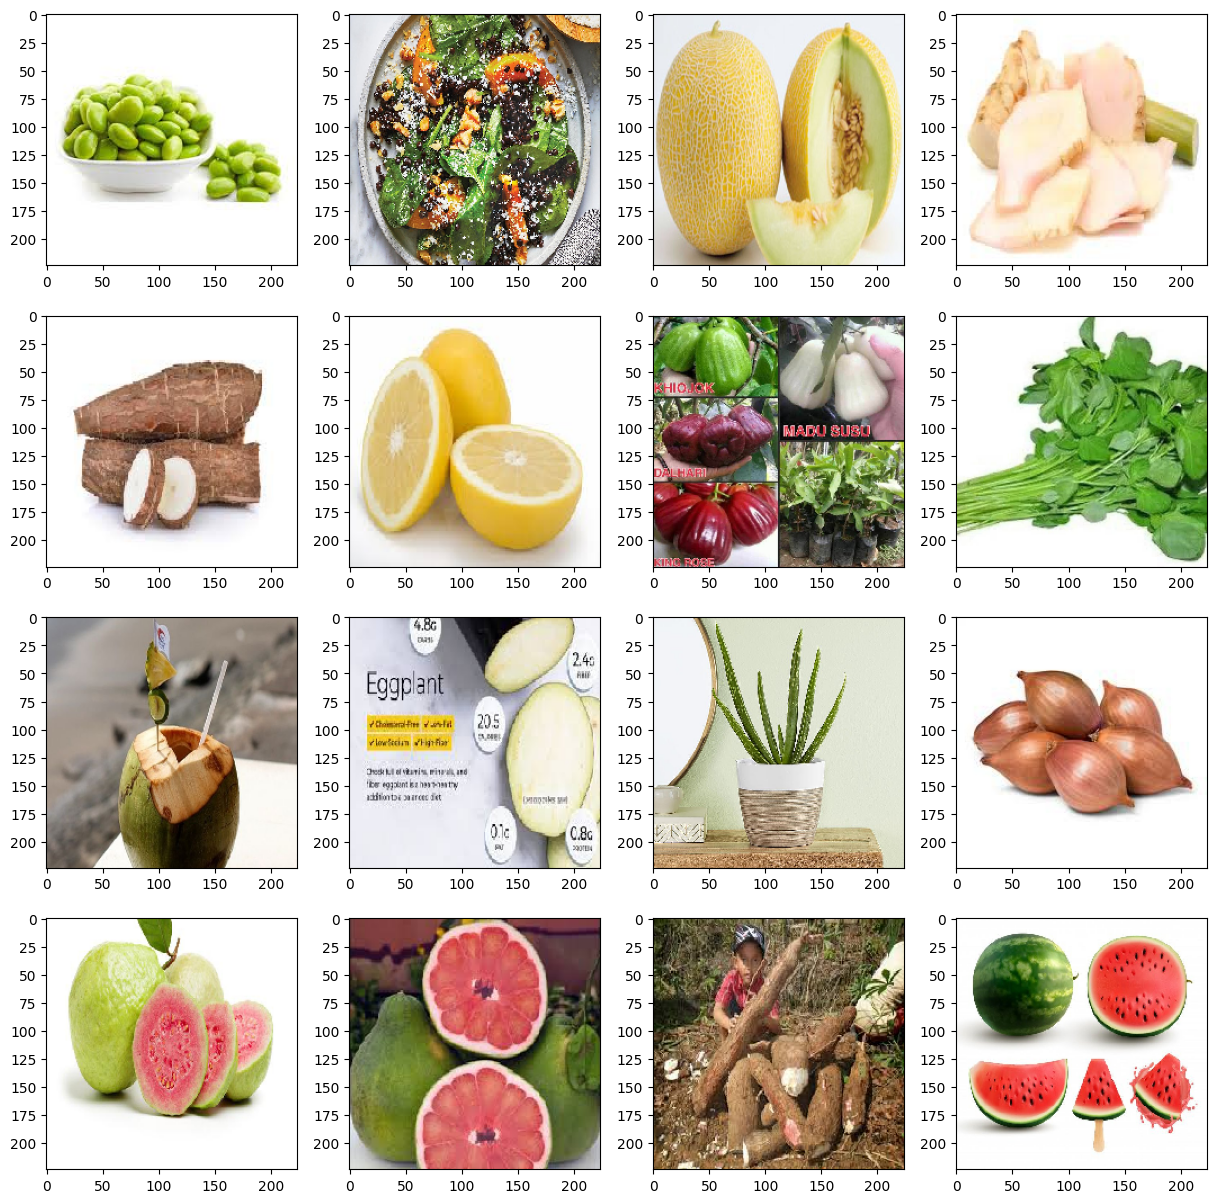

In [7]:
x_train = []
c = 0
for feature, label in train_generator:
    x_train.append(np.array(feature))
    c += 1
    if c == 1:
        break

x_train = np.array(x_train)
print(x_train.shape)
x_train = np.reshape(x_train, (32, 224, 224, 3))
print(x_train.shape)

fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i in range(0, 16):
    ax[int(i / 4), (i % 4)].imshow(x_train[i])

# Proponowana architektura

Input 224x224x3  

Conv2D 64, 3x3, relu  
MaxPooling 2x2  

Conv2D 64, 3x3, relu  
MaxPooling 2x2  

Conv2D 64, 3x3, relu  
MaxPooling 2x2  

Flatten  
Dropout (0.2 - 0.5)  

Dense 128, relu  
Dropout (0.2 - 0.5) 

Dense 30, softmax  

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

def create_model_v1(activation_function, filters_list, dense_number, dropout_list):
    # Definiowanie modelu z podaną architekturą
    model = Sequential([
        # Warstwa wejściowa: Input 224x224x3 jest domyślnie określona przez target_size w generatorze
        # Pierwsza warstwa konwolucyjna
        Conv2D(filters_list[0], (3, 3), activation=activation_function, input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),

        # Druga warstwa konwolucyjna
        Conv2D(filters_list[1], (3, 3), activation=activation_function),
        MaxPooling2D(2, 2),

        # Trzecia warstwa konwolucyjna
        Conv2D(filters_list[2], (3, 3), activation=activation_function),
        MaxPooling2D(2, 2),

        # Spłaszczanie danych do jednowymiarowej tablicy
        Flatten(),

        # Dropout (0.2 - 0.5 lub brak), użyjemy średniej wartości 0.35
        Dropout(dropout_list[0]),

        # Pierwsza warstwa gęsta
        Dense(dense_number, activation=activation_function),
        Dropout(dropout_list[0]),

        # Warstwa wyjściowa
        Dense(30, activation='softmax')
    ])
    return model

def create_model_v2(activation_function, filters_list, dense_number, dropout_list):
    # Definiowanie modelu z podaną architekturą
    model = Sequential([
        # Warstwa wejściowa: Input 224x224x3 jest domyślnie określona przez target_size w generatorze
        # Pierwsza warstwa konwolucyjna
        Conv2D(filters_list[0], (3, 3), activation=activation_function, input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),

        # Druga warstwa konwolucyjna
        Conv2D(filters_list[1], (3, 3), activation=activation_function),
        MaxPooling2D(2, 2),

        # Spłaszczanie danych do jednowymiarowej tablicy
        Flatten(),

        # Dropout (0.2 - 0.5 lub brak), użyjemy średniej wartości 0.35
        Dropout(dropout_list[0]),

        # Pierwsza warstwa gęsta
        Dense(dense_number, activation=activation_function),
        Dropout(dropout_list[0]),

        # Warstwa wyjściowa
        Dense(30, activation='softmax')
    ])
    return model

In [8]:
def plot_accuracies(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs

    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and testing accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['Training', 'testing'])
    plt.show()
    print("")

    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and testing loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['Training', 'testing'])
    plt.show()

# Trenowanie modeli

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 64)      

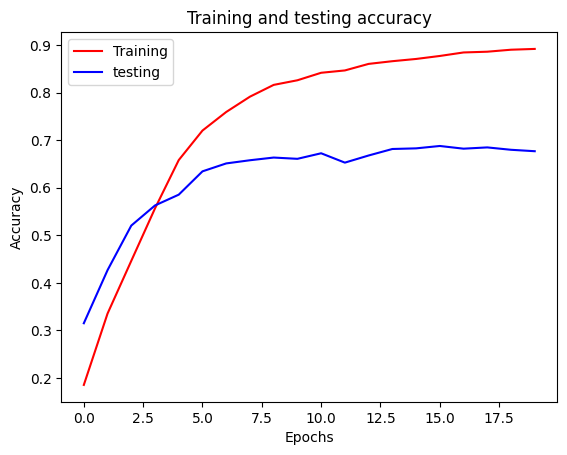

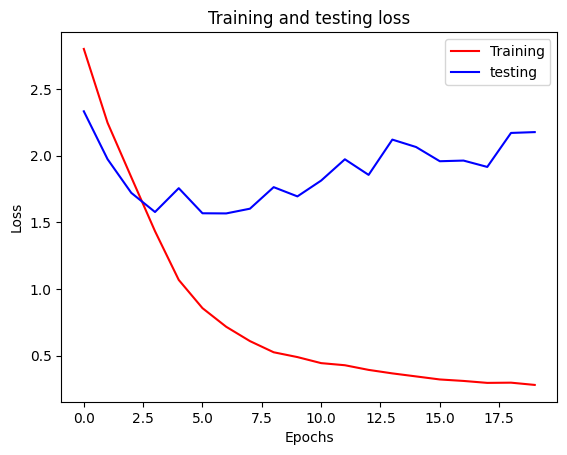

In [13]:
# Dane modelu #1
model_name = 'best_model_nr1'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 64)      

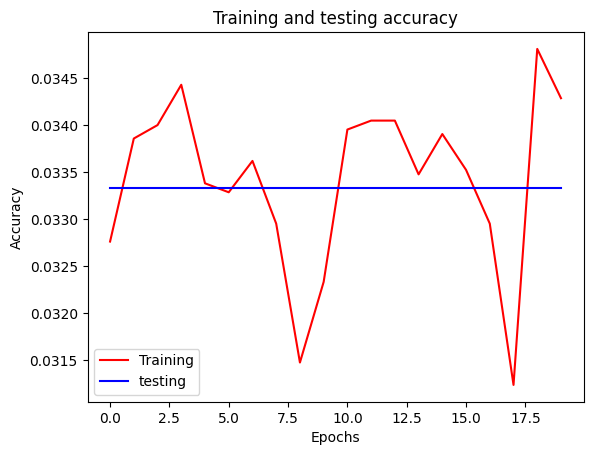

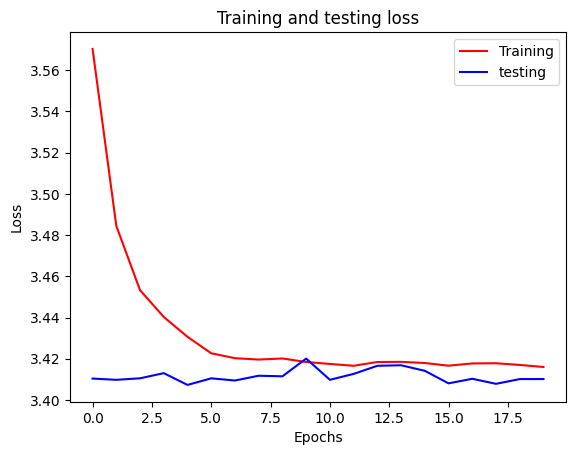

In [14]:
# Dane modelu #2 aktywacja sigmoid
model_name = 'best_model_nr2'
activation_function = 'sigmoid'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 64)      

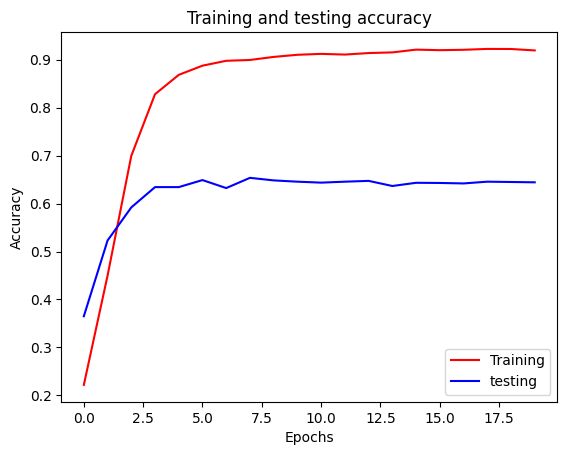

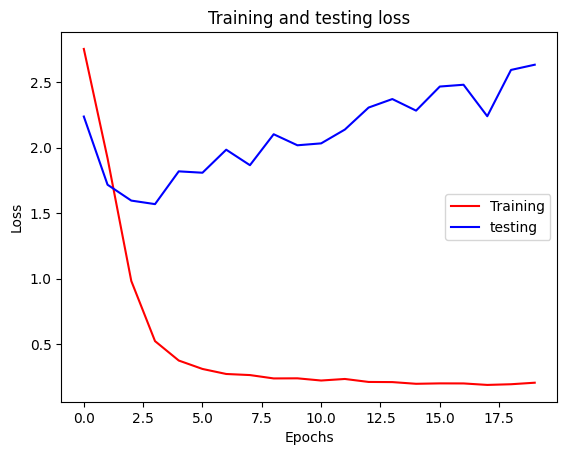

In [15]:
# Dane modelu #3 aktywacja gelu
model_name = 'best_model_nr3'
activation_function = 'gelu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 26, 26, 64)      

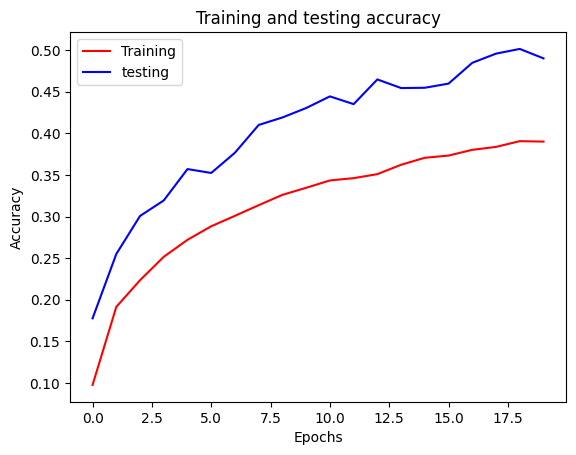

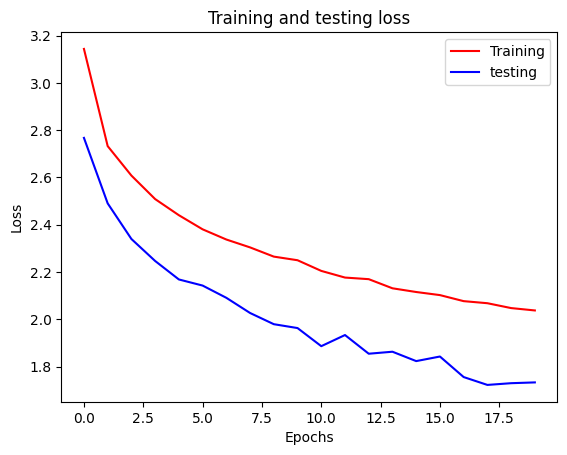

In [16]:
# Dane modelu #4 augmentacja
model_name = 'best_model_nr4'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 26, 26, 64)      

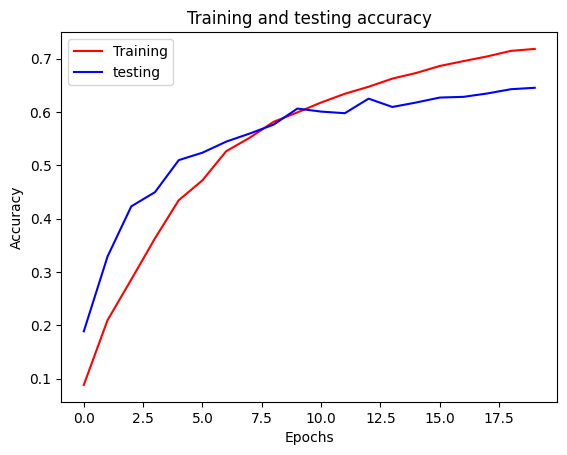

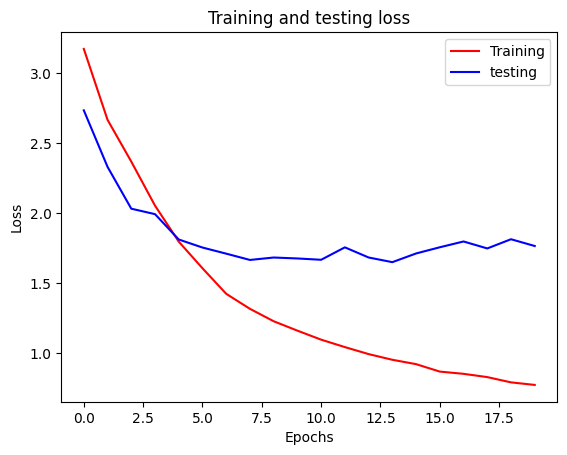

In [17]:
# Dane modelu #5 mniejsza warstwa wyjściowa
model_name = 'best_model_nr5'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 64
dropout_list = [0.35, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 26, 64)      

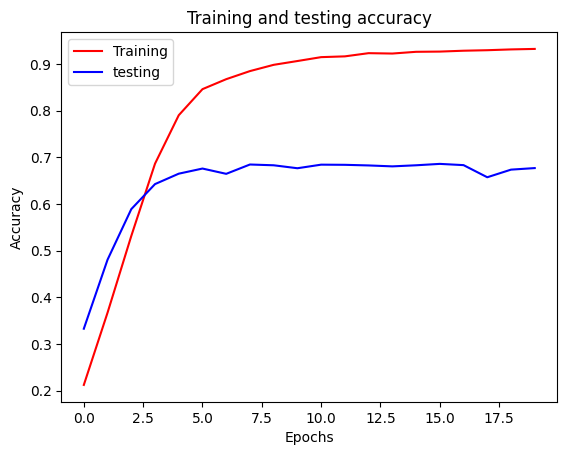

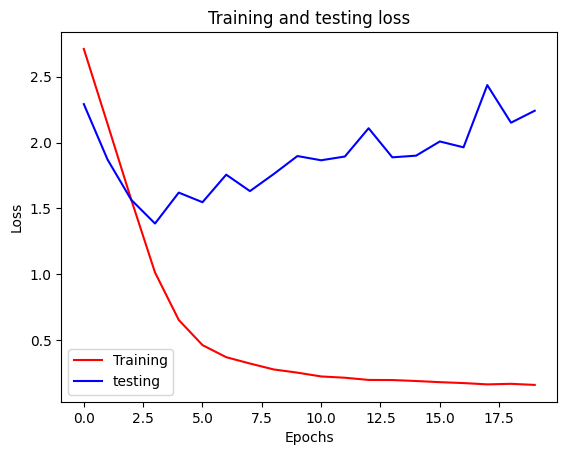

In [18]:
# Dane modelu #6 większa warstwa wyjściowa
model_name = 'best_model_nr6'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 256
dropout_list = [0.35, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 26, 26, 64)      

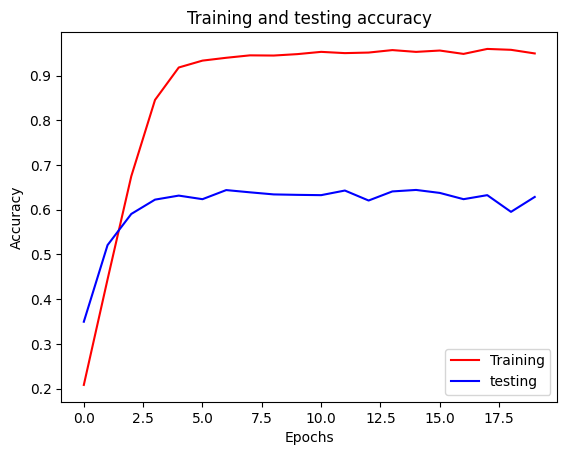

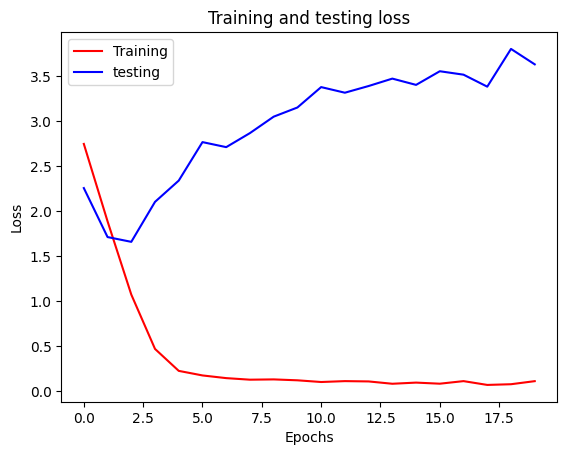

In [19]:
# Dane modelu #7 bez pierwszego dropouta
model_name = 'best_model_nr7'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 26, 26, 64)     

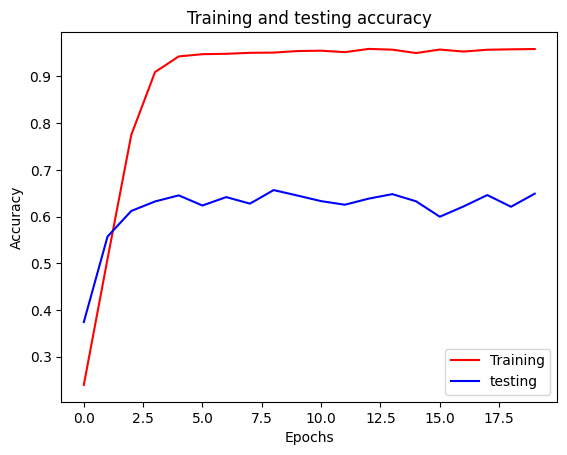

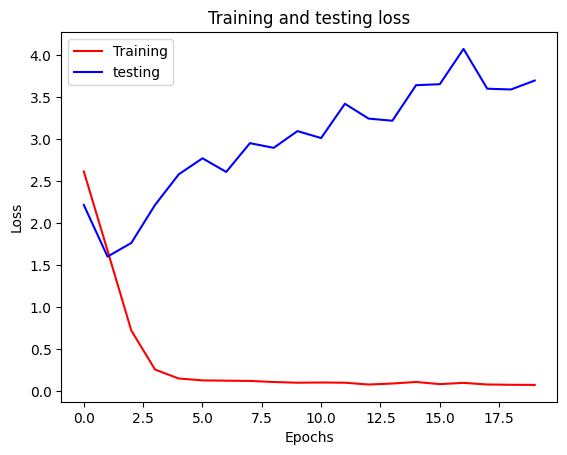

In [20]:
# Dane modelu #8 bez pierwszego dropouta, mniejszy dropout 0.2
model_name = 'best_model_nr8'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0, 0.2]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 26, 26, 64)     

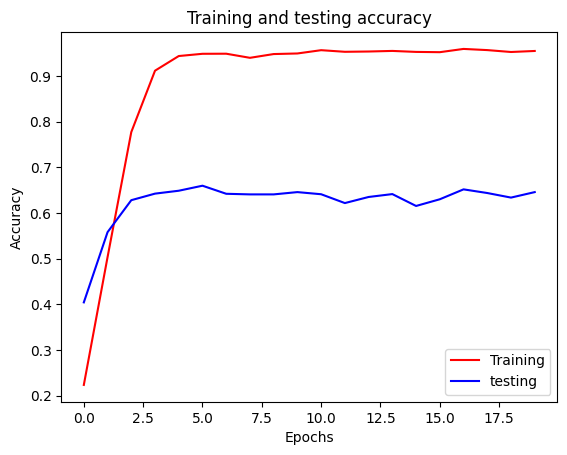

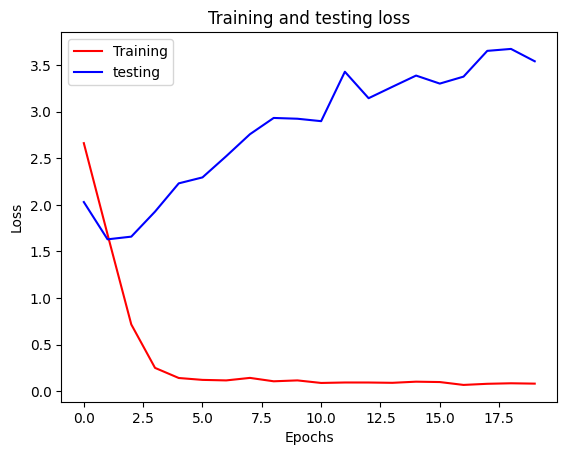

In [21]:
# Dane modelu #9 bez pierwszego dropouta, większy dropout 0.5
model_name = 'best_model_nr9'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 26, 26, 64)     

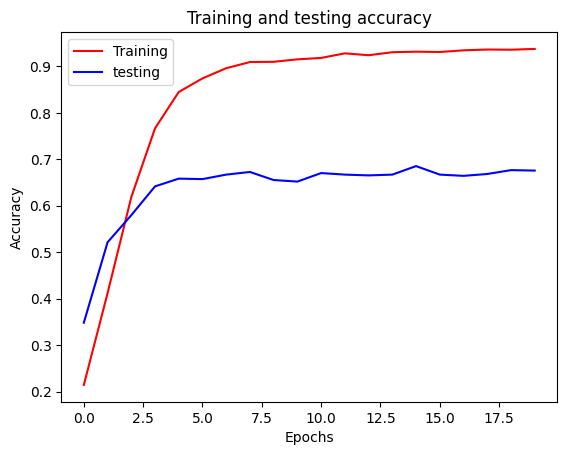

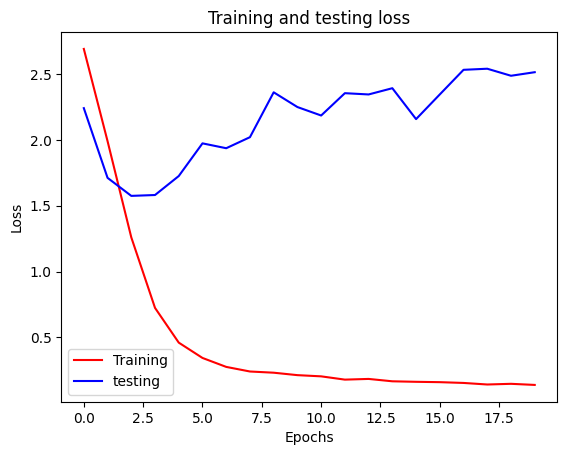

In [22]:
# Dane modelu #10 mniejszy dropout 0.2
model_name = 'best_model_nr10'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.2, 0.2]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 26, 26, 64)     

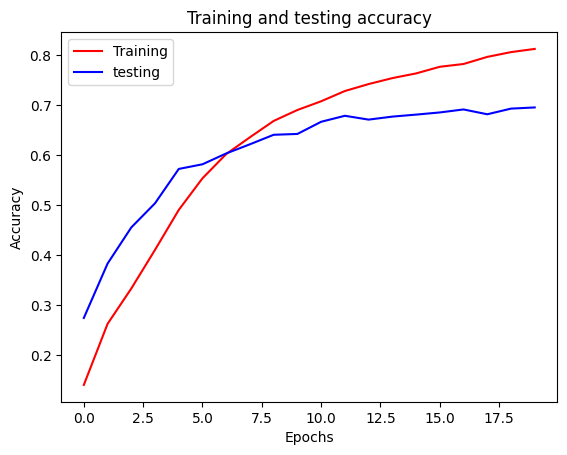

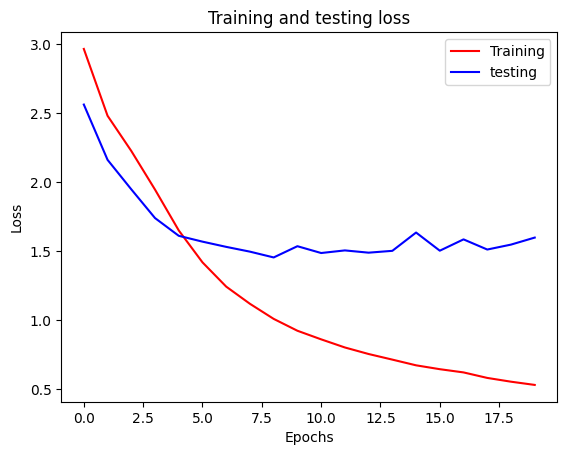

In [23]:
# Dane modelu #11 większy dropout 0.5
model_name = 'best_model_nr11'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.5, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

2024-01-10 21:12:41.191012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.191080: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.191097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.447632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.447676: I external/local_xla/xla/stream_executor

Epoch 1/20


2024-01-10 21:12:42.729279: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-10 21:12:42.967536: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 21:12:44.237357: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 21:12:44.667823: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efa4cd1feb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 21:12:44.667851: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-10 21:12:44.678778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704917564.772709    1084 device_compiler.

657/657 [==============================] - ETA: 0s - loss: 3.4143 - accuracy: 0.0311

/home/pawel/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


657/657 [==============================] - 115s 162ms/step - loss: 3.4143 - accuracy: 0.0311 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 2/20
657/657 [==============================] - 86s 130ms/step - loss: 3.4020 - accuracy: 0.0317 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 3/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4017 - accuracy: 0.0312 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 4/20
657/657 [==============================] - 86s 131ms/step - loss: 3.4017 - accuracy: 0.0317 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 5/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4017 - accuracy: 0.0321 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 6/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4016 - accuracy: 0.0314 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 7/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4016 - accuracy: 0.0319 - val_loss: 3.4012 - val_accuracy: 0.

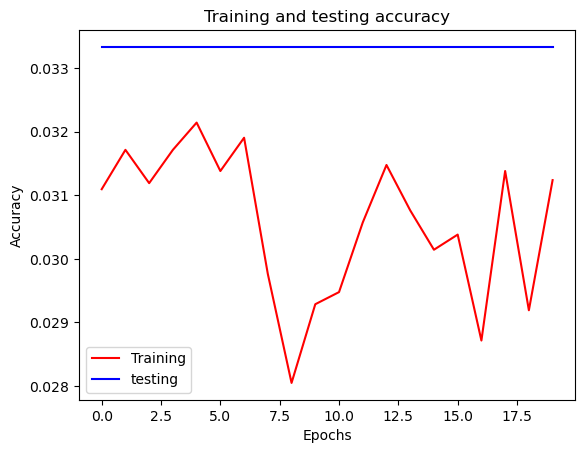

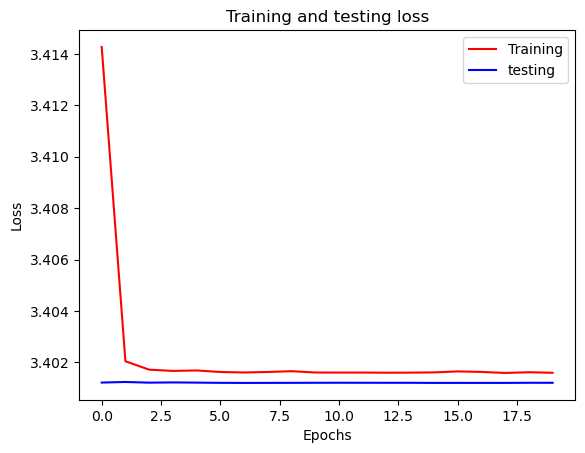

In [9]:
# Dane modelu #12 więcej filtrów
model_name = 'best_model_nr12'
activation_function = 'relu'
filters_list = [128, 128, 128]
dense_number = 128
dropout_list = [0.5, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 186624)            0         
                                                                 
 dropout_30 (Dropout)        (None, 186624)          

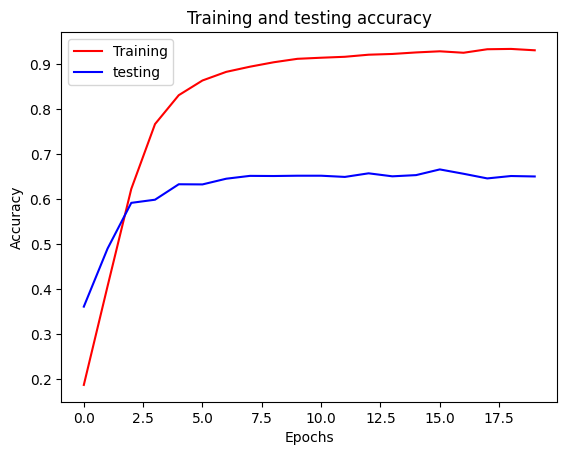

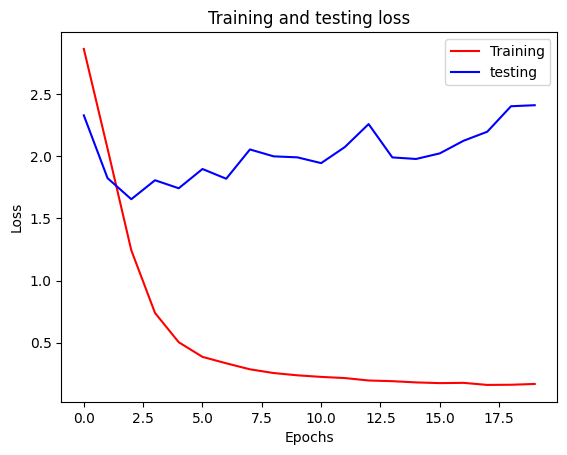

In [26]:
# Dane modelu #13 
model_name = 'best_model_nr13'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 186624)            0         
                                                                 
 dropout_32 (Dropout)        (None, 186624)          

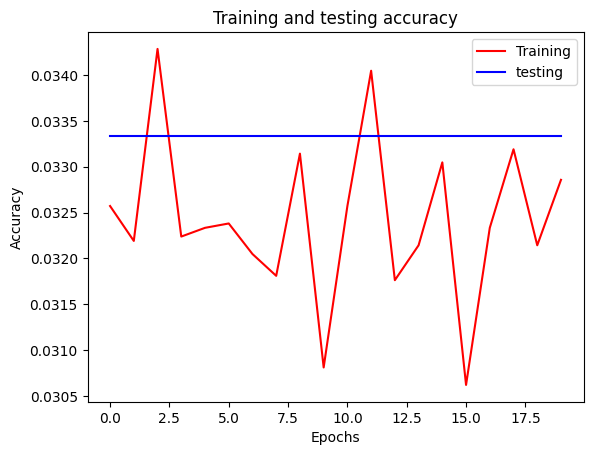

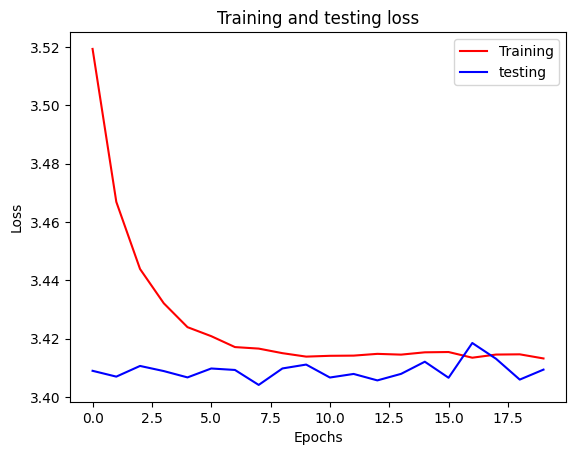

In [27]:
# Dane modelu #14 aktywacja sigmoid
model_name = 'best_model_nr14'
activation_function = 'sigmoid'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dropout_2 (Dropout)         (None, 186624)           

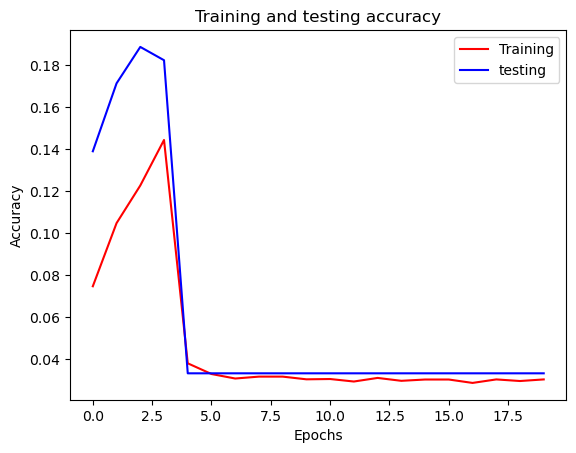

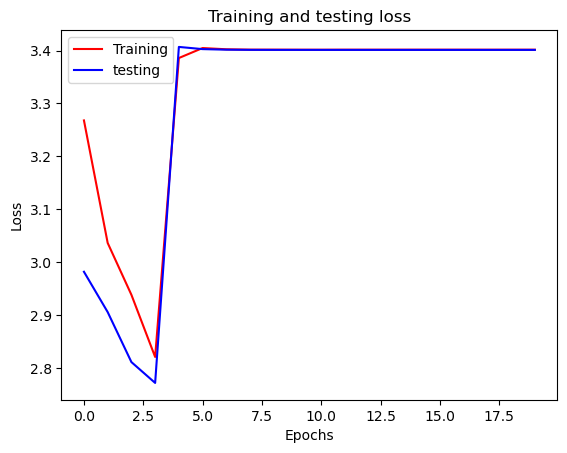

In [10]:
# Dane modelu #15 aktywacja gelu
model_name = 'best_model_nr15'
activation_function = 'gelu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dropout_4 (Dropout)         (None, 186624)           

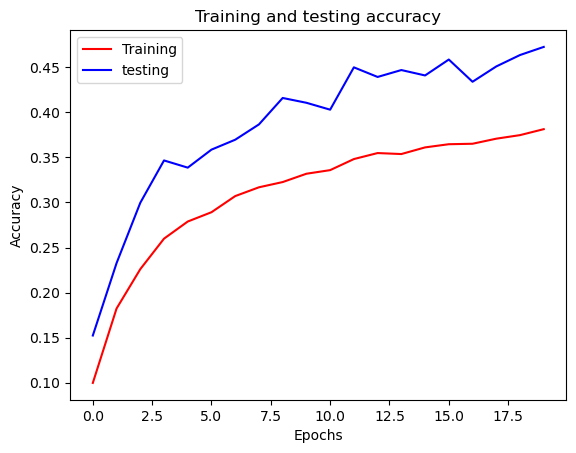

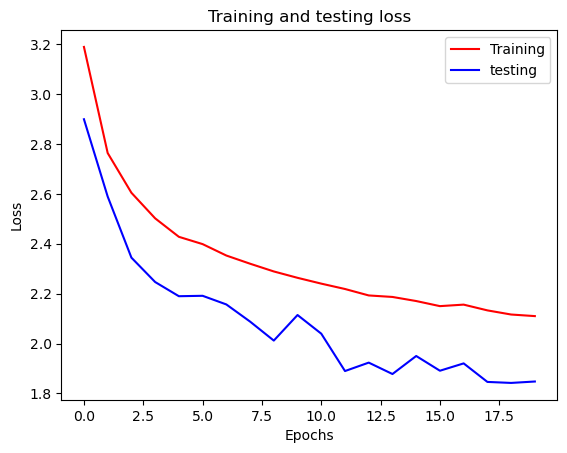

In [11]:
# Dane modelu #16 augmentacja
model_name = 'best_model_nr16'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator_aug # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

In [32]:
# Dane modelu #17 mniejsza warstwa wyjściowa
model_name = 'best_model_nr17'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 64
dropout_list = [0.35, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 186624)            0         
                                                                 
 dropout_42 (Dropout)        (None, 186624)          

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_21/dropout_42/dropout/Mul' defined at (most recent call last):
    File "D:\anaconda3\envs\Python37\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "D:\anaconda3\envs\Python37\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\anaconda3\envs\Python37\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\anaconda3\envs\Python37\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda3\envs\Python37\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "D:\anaconda3\envs\Python37\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "D:\anaconda3\envs\Python37\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_11476\431145509.py", line 22, in <module>
      batch_size = 8
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\layers\regularization\dropout.py", line 117, in call
      training, dropped_inputs, lambda: tf.identity(inputs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\control_flow_util.py", line 109, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\layers\regularization\dropout.py", line 113, in dropped_inputs
      inputs, self.rate, noise_shape=self._get_noise_shape(inputs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\backend.py", line 2166, in dropout
      seed=self.make_legacy_seed(),
Node: 'sequential_21/dropout_42/dropout/Mul'
failed to allocate memory
	 [[{{node sequential_21/dropout_42/dropout/Mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_817114]

In [33]:
# Dane modelu #18 większa warstwa wyjściowa
model_name = 'best_model_nr18'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 256
dropout_list = [0.35, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 186624)            0         
                                                                 
 dropout_44 (Dropout)        (None, 186624)          

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_22/conv2d_59/Relu' defined at (most recent call last):
    File "D:\anaconda3\envs\Python37\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "D:\anaconda3\envs\Python37\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\anaconda3\envs\Python37\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\anaconda3\envs\Python37\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda3\envs\Python37\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "D:\anaconda3\envs\Python37\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "D:\anaconda3\envs\Python37\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\anaconda3\envs\Python37\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "D:\anaconda3\envs\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_11476\4219400651.py", line 22, in <module>
      batch_size = 8
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\activations.py", line 318, in relu
      x, alpha=alpha, max_value=max_value, threshold=threshold
    File "C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_22/conv2d_59/Relu'
OOM when allocating tensor with shape[32,64,222,222] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_22/conv2d_59/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_818002]

In [34]:
# Dane modelu #19 bez dropout
model_name = 'best_model_nr19'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[186624,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [35]:
# Dane modelu #20 bez dropout, mniejsza wartość 0.2
model_name = 'best_model_nr20'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0, 0.2]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[186624,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [36]:
# Dane modelu #21 bez dropout, mniejsza wartość 0.5
model_name = 'best_model_nr21'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[186624,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [37]:
# Dane modelu #22 mniejsza wartość dropout 0.2
model_name = 'best_model_nr22'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.2, 0.2]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[186624,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [38]:
# Dane modelu #23 większa wartość dropout 0.5
model_name = 'best_model_nr23'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.5, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[186624,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [39]:
# Dane modelu #24 więcej filtrów
model_name = 'best_model_nr24'
activation_function = 'relu'
filters_list = [128, 128]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[373248,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

# Testowanie modelu

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Wczytanie modelu
model = load_model('final_model.h5')

# Testowanie modelu na danych testowych
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generowanie przewidywań na danych testowych
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Etykiety rzeczywiste
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

# Wyświetlanie raportu klasyfikacji
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Wyświetlanie macierzy pomyłek
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)


188/188 [==============================] - 83s 441ms/step - loss: 2.2131 - accuracy: 0.5723
Test Loss: 2.2131292819976807
Test Accuracy: 0.5723333358764648
188/188 [==============================] - 80s 424ms/step
               precision    recall  f1-score   support

     aloevera       0.01      0.01      0.01       200
       banana       0.05      0.04      0.05       200
      bilimbi       0.04      0.04      0.04       200
   cantaloupe       0.06      0.05      0.06       200
      cassava       0.04      0.06      0.05       200
      coconut       0.03      0.01      0.02       200
         corn       0.02      0.03      0.02       200
     cucumber       0.05      0.04      0.04       200
      curcuma       0.03      0.04      0.03       200
     eggplant       0.02      0.03      0.02       200
     galangal       0.03      0.04      0.04       200
       ginger       0.06      0.07      0.06       200
        guava       0.05      0.04      0.04       200
         kale  

## Testowanie kolejnych modeli

In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# Function to evaluate a model
def evaluate_model(model_path, test_generator):
    # Load model
    model = load_model(model_path)

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Model: {model_path}")
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Generate predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Real labels
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())  

    # Classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    print(conf_matrix)


architecture1 = os.path.join('models', 'model1')
architecture2 = os.path.join('models', 'model2')

In [16]:
import os
model_path = os.path.join(architecture1, f'best_model_nr1.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 25s 131ms/step - loss: 2.4802 - accuracy: 0.6277
Model: models/model1/best_model_nr1.h5
Test Loss: 2.480153799057007
Test Accuracy: 0.6276666522026062
188/188 [==============================] - 24s 124ms/step
               precision    recall  f1-score   support

     aloevera       0.05      0.04      0.05       200
       banana       0.03      0.03      0.03       200
      bilimbi       0.04      0.04      0.04       200
   cantaloupe       0.04      0.04      0.04       200
      cassava       0.03      0.03      0.03       200
      coconut       0.05      0.03      0.03       200
         corn       0.03      0.03      0.03       200
     cucumber       0.04      0.04      0.04       200
      curcuma       0.03      0.04      0.03       200
     eggplant       0.03      0.04      0.03       200
     galangal       0.04      0.04      0.04       200
       ginger       0.04      0.06      0.05       200
        guava       0.03      0.

In [17]:
import os
model_path = os.path.join(architecture1, f'best_model_nr2.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 25s 129ms/step - loss: 3.4104 - accuracy: 0.0333
Model: models/model1/best_model_nr2.h5
Test Loss: 3.4103941917419434
Test Accuracy: 0.03333333507180214
188/188 [==============================] - 23s 123ms/step
               precision    recall  f1-score   support

     aloevera       0.00      0.00      0.00       200
       banana       0.00      0.00      0.00       200
      bilimbi       0.00      0.00      0.00       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.00      0.00      0.00       200
      coconut       0.00      0.00      0.00       200
         corn       0.00      0.00      0.00       200
     cucumber       0.00      0.00      0.00       200
      curcuma       0.00      0.00      0.00       200
     eggplant       0.00      0.00      0.00       200
     galangal       0.00      0.00      0.00       200
       ginger       0.00      0.00      0.00       200
        guava       0.00      

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
import os
model_path = os.path.join(architecture1, f'best_model_nr3.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 120ms/step - loss: 2.1989 - accuracy: 0.5967
Model: models/model1/best_model_nr3.h5
Test Loss: 2.198867082595825
Test Accuracy: 0.596666693687439
188/188 [==============================] - 22s 118ms/step
               precision    recall  f1-score   support

     aloevera       0.04      0.04      0.04       200
       banana       0.05      0.04      0.04       200
      bilimbi       0.02      0.01      0.02       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.01      0.01      0.01       200
      coconut       0.03      0.01      0.02       200
         corn       0.03      0.04      0.03       200
     cucumber       0.02      0.02      0.02       200
      curcuma       0.02      0.03      0.02       200
     eggplant       0.06      0.04      0.05       200
     galangal       0.03      0.04      0.03       200
       ginger       0.04      0.04      0.04       200
        guava       0.05      0.0

In [19]:
import os
model_path = os.path.join(architecture1, f'best_model_nr4.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 118ms/step - loss: 1.7442 - accuracy: 0.4747
Model: models/model1/best_model_nr4.h5
Test Loss: 1.7442309856414795
Test Accuracy: 0.47466665506362915
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.04      0.01      0.02       200
       banana       0.03      0.03      0.03       200
      bilimbi       0.03      0.02      0.02       200
   cantaloupe       0.02      0.04      0.03       200
      cassava       0.03      0.03      0.03       200
      coconut       0.04      0.04      0.04       200
         corn       0.02      0.03      0.02       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.02      0.03      0.03       200
     eggplant       0.05      0.04      0.05       200
     galangal       0.04      0.04      0.04       200
       ginger       0.03      0.06      0.04       200
        guava       0.03      

In [20]:
import os
model_path = os.path.join(architecture1, f'best_model_nr5.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 117ms/step - loss: 2.1892 - accuracy: 0.5842
Model: models/model1/best_model_nr5.h5
Test Loss: 2.1891677379608154
Test Accuracy: 0.5841666460037231
188/188 [==============================] - 22s 119ms/step
               precision    recall  f1-score   support

     aloevera       0.02      0.01      0.01       200
       banana       0.03      0.02      0.02       200
      bilimbi       0.01      0.01      0.01       200
   cantaloupe       0.02      0.02      0.02       200
      cassava       0.03      0.03      0.03       200
      coconut       0.01      0.01      0.01       200
         corn       0.03      0.04      0.04       200
     cucumber       0.03      0.05      0.04       200
      curcuma       0.02      0.03      0.02       200
     eggplant       0.02      0.02      0.02       200
     galangal       0.04      0.05      0.05       200
       ginger       0.01      0.01      0.01       200
        guava       0.03      0

In [21]:
import os
model_path = os.path.join(architecture1, f'best_model_nr6.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 118ms/step - loss: 2.5125 - accuracy: 0.6333
Model: models/model1/best_model_nr6.h5
Test Loss: 2.512491464614868
Test Accuracy: 0.6333333253860474
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.02      0.01      0.02       200
       banana       0.01      0.01      0.01       200
      bilimbi       0.03      0.04      0.03       200
   cantaloupe       0.01      0.01      0.01       200
      cassava       0.06      0.06      0.06       200
      coconut       0.04      0.03      0.03       200
         corn       0.05      0.09      0.06       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.06      0.06      0.06       200
     eggplant       0.02      0.01      0.02       200
     galangal       0.02      0.02      0.02       200
       ginger       0.06      0.07      0.07       200
        guava       0.02      0.

In [22]:
import os
model_path = os.path.join(architecture1, f'best_model_nr7.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 24s 125ms/step - loss: 4.3591 - accuracy: 0.5842
Model: models/model1/best_model_nr7.h5
Test Loss: 4.359147548675537
Test Accuracy: 0.5841666460037231
188/188 [==============================] - 23s 120ms/step
               precision    recall  f1-score   support

     aloevera       0.03      0.02      0.02       200
       banana       0.03      0.02      0.02       200
      bilimbi       0.03      0.03      0.03       200
   cantaloupe       0.05      0.03      0.03       200
      cassava       0.02      0.03      0.02       200
      coconut       0.04      0.02      0.03       200
         corn       0.05      0.06      0.05       200
     cucumber       0.06      0.04      0.05       200
      curcuma       0.02      0.03      0.03       200
     eggplant       0.02      0.01      0.02       200
     galangal       0.03      0.03      0.03       200
       ginger       0.04      0.05      0.04       200
        guava       0.03      0.

In [23]:
import os
model_path = os.path.join(architecture1, f'best_model_nr8.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 124ms/step - loss: 3.6282 - accuracy: 0.6000
Model: models/model1/best_model_nr8.h5
Test Loss: 3.6282145977020264
Test Accuracy: 0.6000000238418579
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.01      0.01      0.01       200
       banana       0.03      0.01      0.02       200
      bilimbi       0.01      0.01      0.01       200
   cantaloupe       0.02      0.01      0.01       200
      cassava       0.04      0.04      0.04       200
      coconut       0.02      0.01      0.01       200
         corn       0.01      0.01      0.01       200
     cucumber       0.01      0.01      0.01       200
      curcuma       0.00      0.01      0.00       200
     eggplant       0.02      0.03      0.02       200
     galangal       0.03      0.04      0.04       200
       ginger       0.04      0.04      0.04       200
        guava       0.04      0

In [24]:
import os
model_path = os.path.join(architecture1, f'best_model_nr9.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 116ms/step - loss: 2.8760 - accuracy: 0.6015
Model: models/model1/best_model_nr9.h5
Test Loss: 2.8760132789611816
Test Accuracy: 0.6014999747276306
188/188 [==============================] - 22s 117ms/step
               precision    recall  f1-score   support

     aloevera       0.02      0.02      0.02       200
       banana       0.02      0.03      0.02       200
      bilimbi       0.05      0.04      0.04       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.02      0.03      0.03       200
      coconut       0.05      0.03      0.03       200
         corn       0.05      0.06      0.05       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.04      0.04      0.04       200
     eggplant       0.02      0.03      0.03       200
     galangal       0.05      0.06      0.05       200
       ginger       0.03      0.03      0.03       200
        guava       0.05      0

In [25]:
import os
model_path = os.path.join(architecture1, f'best_model_nr10.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 116ms/step - loss: 2.7744 - accuracy: 0.6223
Model: models/model1/best_model_nr10.h5
Test Loss: 2.774421453475952
Test Accuracy: 0.6223333477973938
188/188 [==============================] - 22s 115ms/step
               precision    recall  f1-score   support

     aloevera       0.05      0.04      0.04       200
       banana       0.04      0.04      0.04       200
      bilimbi       0.02      0.03      0.02       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.06      0.05      0.06       200
      coconut       0.05      0.03      0.04       200
         corn       0.06      0.10      0.08       200
     cucumber       0.04      0.04      0.04       200
      curcuma       0.05      0.06      0.05       200
     eggplant       0.01      0.01      0.01       200
     galangal       0.02      0.03      0.02       200
       ginger       0.05      0.05      0.05       200
        guava       0.07      0

In [26]:
import os
model_path = os.path.join(architecture1, f'best_model_nr11.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 116ms/step - loss: 1.9650 - accuracy: 0.6387
Model: models/model1/best_model_nr11.h5
Test Loss: 1.9650059938430786
Test Accuracy: 0.6386666893959045
188/188 [==============================] - 22s 116ms/step
               precision    recall  f1-score   support

     aloevera       0.06      0.05      0.06       200
       banana       0.03      0.03      0.03       200
      bilimbi       0.05      0.06      0.05       200
   cantaloupe       0.03      0.04      0.04       200
      cassava       0.03      0.03      0.03       200
      coconut       0.02      0.01      0.01       200
         corn       0.04      0.04      0.04       200
     cucumber       0.03      0.04      0.03       200
      curcuma       0.05      0.06      0.05       200
     eggplant       0.02      0.03      0.03       200
     galangal       0.01      0.01      0.01       200
       ginger       0.03      0.03      0.03       200
        guava       0.02      

In [27]:
import os
model_path = os.path.join(architecture1, f'best_model_nr12.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 119ms/step - loss: 3.4012 - accuracy: 0.0333
Model: models/model1/best_model_nr12.h5
Test Loss: 3.4012160301208496
Test Accuracy: 0.03333333507180214
188/188 [==============================] - 21s 113ms/step
               precision    recall  f1-score   support

     aloevera       0.00      0.00      0.00       200
       banana       0.00      0.00      0.00       200
      bilimbi       0.00      0.00      0.00       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.03      1.00      0.06       200
      coconut       0.00      0.00      0.00       200
         corn       0.00      0.00      0.00       200
     cucumber       0.00      0.00      0.00       200
      curcuma       0.00      0.00      0.00       200
     eggplant       0.00      0.00      0.00       200
     galangal       0.00      0.00      0.00       200
       ginger       0.00      0.00      0.00       200
        guava       0.00     

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
import os
model_path = os.path.join(architecture2, f'best_model_nr13.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 24s 126ms/step - loss: 2.5977 - accuracy: 0.6053
Model: models/model2/best_model_nr13.h5
Test Loss: 2.597714424133301
Test Accuracy: 0.6053333282470703
188/188 [==============================] - 23s 123ms/step
               precision    recall  f1-score   support

     aloevera       0.03      0.02      0.02       200
       banana       0.03      0.02      0.03       200
      bilimbi       0.02      0.03      0.02       200
   cantaloupe       0.02      0.02      0.02       200
      cassava       0.07      0.07      0.07       200
      coconut       0.04      0.02      0.03       200
         corn       0.02      0.02      0.02       200
     cucumber       0.04      0.04      0.04       200
      curcuma       0.05      0.07      0.05       200
     eggplant       0.03      0.03      0.03       200
     galangal       0.03      0.03      0.03       200
       ginger       0.02      0.03      0.03       200
        guava       0.07      0

In [29]:
import os
model_path = os.path.join(architecture2, f'best_model_nr14.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 123ms/step - loss: 3.4089 - accuracy: 0.0333
Model: models/model2/best_model_nr14.h5
Test Loss: 3.408933162689209
Test Accuracy: 0.03333333507180214
188/188 [==============================] - 23s 122ms/step
               precision    recall  f1-score   support

     aloevera       0.00      0.00      0.00       200
       banana       0.00      0.00      0.00       200
      bilimbi       0.00      0.00      0.00       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.00      0.00      0.00       200
      coconut       0.00      0.00      0.00       200
         corn       0.00      0.00      0.00       200
     cucumber       0.00      0.00      0.00       200
      curcuma       0.00      0.00      0.00       200
     eggplant       0.00      0.00      0.00       200
     galangal       0.00      0.00      0.00       200
       ginger       0.00      0.00      0.00       200
        guava       0.00      

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
import os
model_path = os.path.join(architecture2, f'best_model_nr15.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 122ms/step - loss: 2.8158 - accuracy: 0.1693
Model: models/model2/best_model_nr15.h5
Test Loss: 2.815804958343506
Test Accuracy: 0.1693333387374878
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.07      0.03      0.04       200
       banana       0.02      0.03      0.03       200
      bilimbi       0.03      0.04      0.03       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.03      0.10      0.05       200
      coconut       0.04      0.01      0.02       200
         corn       0.03      0.15      0.06       200
     cucumber       0.03      0.01      0.01       200
      curcuma       0.02      0.01      0.01       200
     eggplant       0.02      0.01      0.01       200
     galangal       0.02      0.02      0.02       200
       ginger       0.03      0.11      0.05       200
        guava       0.00      0

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
import os
model_path = os.path.join(architecture2, f'best_model_nr16.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 120ms/step - loss: 1.9413 - accuracy: 0.4415
Model: models/model2/best_model_nr16.h5
Test Loss: 1.9413349628448486
Test Accuracy: 0.4415000081062317
188/188 [==============================] - 22s 118ms/step
               precision    recall  f1-score   support

     aloevera       0.03      0.02      0.02       200
       banana       0.03      0.01      0.02       200
      bilimbi       0.02      0.01      0.01       200
   cantaloupe       0.02      0.01      0.01       200
      cassava       0.04      0.07      0.05       200
      coconut       0.04      0.07      0.05       200
         corn       0.03      0.03      0.03       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.04      0.06      0.04       200
     eggplant       0.02      0.03      0.02       200
     galangal       0.06      0.07      0.06       200
       ginger       0.04      0.06      0.05       200
        guava       0.02      